
# Proyecto de Procesamiento de Lenguaje Natural

Autores:
- Manzanares Peña Jorge Luis
- Salazar Domínguez Jesús Eduardo

Fuente Dataset:
- https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?select=train.csv

IDs de las categorías de noticias:
- 0: Internacionales
- 1: Deportes
- 2: Negocios
- 3: Ciencia y Tecnología


## Preprocesamiento

- Importación de bibliotecas

In [1]:
import pandas as pd
import string
import sklearn as sk
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plot
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import re

- Descarga de archivos desde Github.

In [2]:
!wget -O test.csv   https://raw.githubusercontent.com/JesusESD/NLPProject/main/Data/test.csv
!wget -O train.csv  https://raw.githubusercontent.com/JesusESD/NLPProject/main/Data/train.csv
!wget -O val.csv    https://raw.githubusercontent.com/JesusESD/NLPProject/main/Data/val.csv

--2023-06-21 14:22:22--  https://raw.githubusercontent.com/JesusESD/NLPProject/main/Data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1831783 (1.7M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]   1.75M  --.-KB/s    in 0.06s   

2023-06-21 14:22:23 (31.5 MB/s) - ‘test.csv’ saved [1831783/1831783]

--2023-06-21 14:22:23--  https://raw.githubusercontent.com/JesusESD/NLPProject/main/Data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27234338 (26M) [text/plain]
Saving to: ‘t

- Definición y muestra de los dataframes para entrenamiento (train-df), validación (val_df) y evaluación (test_df).

In [3]:
test_df  = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
val_df   = pd.read_csv('val.csv')

In [4]:
train_df.head()

,Class,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
val_df.head()

,Class,Title,Description
0,3,Permira links with Apollo to join Toys #39;R ...,"Permira, the private equity firm that owns New..."
1,3,3Com to buy TippingPoint for \$430M,"DECEMBER 13, 2004 (IDG NEWS SERVICE) - 3Com Co..."
2,3,Icahn Files Suit vs. Mylan Laboratories,Billionaire investor Carl Icahn filed a federa...
3,3,Fiat dismisses GM threat that car unit might g...,Fiat threw down the gauntlet to General Motors...
4,4,NASA: Mondays The Best Time To See Geminid Met...,Stargazers can catch a spectacular sight if th...


In [6]:
test_df.head()

,Class,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


- Elimina registros duplicados según el campo *Description*.

In [7]:
train_df = train_df.drop_duplicates(subset=['Description'])
val_df = val_df.drop_duplicates(subset=['Description'])
test_df = test_df.drop_duplicates(subset=['Description'])

- Ordenamiento ascendente de registros según el campo *Description*.

In [8]:
train_df.sort_values(by='Description', ascending=True, inplace=False)

,Class,Title,Description
38968,2,The Rundown,1 Southern California at Stanford &lt;em&...
83160,1,WorldCom Investors Settle,A federal judge approved a \$2.575 billion ...
54379,3,"Johnson Controls Sees Revenue, Earns Up",CHICAGO (Reuters) - Auto parts supplier Joh...
58997,1,Japan's Wide Role in Afghanistan,"Japan's Foreign Ministry spokesman, Hats..."
104138,4,Chip Sales Rise 1.5 Pct in October from September,NEW YORK (Reuters) - Worldwide semiconducto...
...,...,...,...
17055,1,Malaysia court overturns Anwar sodomy ruling,"years in jail, overturning his conviction for ..."
12762,3,Drug to Help Avert Blindness Moves Closer to A...,yetech Pharmaceuticals #39; drug to treat the ...
19295,2,No. 25 Purdue Opens With a 51-0 Rout of Syracuse,yle Orton passed for 287 yards and a career-hi...
2979,2,American Cyclist Hamilton Wins Time Trial,yler Hamilton and Bobby Julich showed that the...


In [9]:
val_df.sort_values(by='Description', ascending=True, inplace=False)

,Class,Title,Description
6240,3,An Optimistic Hiring Forecast,Chief executives in the Washington-Baltimor...
2100,3,LATEST FUTURES NEWS,2004-12-15 11:01:48 Oil - Brent higher on US...
5378,1,Dangers on the Ground in Iraq Lead to Increase...,"AL UDEID AIR BASE, Qatar, Dec. 11 -- In an e..."
2543,4,A Push to Restrict Sales of Video Games,CHICAGO. Dec. 15 -- Decrying violence in fas...
1394,1,"Turkish Engineer, 2 Aides Missing in Afghanistan","KABUL, Afghanistan, Dec. 14 -- A Turkish eng..."
...,...,...,...
322,4,Sprint's Planned Nextel Deal Builds on Wireles...,washingtonpost.com - When Gary D. Forsee took ...
1126,3,"For Sprint and Nextel, the Struggle Is Ahead",which could come as early as today - they will...
4659,3,Consumer prices in US edge higher,which jumped steeply the previous month - incr...
4374,4,Zafi.D Infects 1 in 10 E-mails,which spreads through e-mail that appears to c...


In [10]:
test_df.sort_values(by='Description', ascending=True, inplace=False)

,Class,Title,Description
4562,3,Consumer Confidence Hits 7-Month Low,NEW YORK (Reuters) - U.S. consumers turned m...
6698,1,Terms of Endearment,"Seems that the Bush administration, unlike p..."
6465,1,Forecast Frosty for U.S.-Canadian Ties,TORONTO -- The weather won't be the only thi...
170,4,10 features for a perfect browser,There are some great browsers out there. ...
5775,3,SEC Charges Hollinger's Black with Fraud,WASHINGTON (Reuters) - U.S. regulators filed...
...,...,...,...
7135,3,The relief of shedding a big ball and chain: H...,"which owns fund manager Henderson, - yesterday..."
3116,4,OPM Delving Deeper Into Employees #39; Backgro...,which sets hiring and employment standards for...
4996,2,Diva gallops into history,"wind, water and Makybe Diva -ll came together ..."
7132,1,Plant a tree at Easter urges Nobel laureate,world to plant trees at Easter as a symbol of ...


- Eliminación cadenas de espacios en el campo *Description*.

In [11]:
train_df = train_df[train_df['Description'].str.strip() != '']

In [12]:
val_df = val_df[val_df['Description'].str.strip() != '']

In [13]:
test_df = test_df[test_df['Description'].str.strip() != '']

- Reconfiguración de índices y validación de tamaño de los dataframes tras su depuración.

In [14]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [15]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

111173
7554
7594


- Creación de una nueva columna (Text) añadiendo el título a la descripción. Esta columna será la utilizada para el entrenamiento de los modelos, ya que proporciona la mayor cantidad de información sobre la noticia.

In [16]:
train_df['Text'] = train_df['Title']+ train_df['Description']
val_df['Text'] = val_df['Title']+ val_df['Description']
test_df['Text'] = test_df['Title']+ test_df['Description']

- Modificación del ID de la categoría de noticia para que se encuentre en el rango [0, 4).

In [17]:
train_df['Class'] = train_df['Class'] - 1
val_df['Class'] = val_df['Class'] - 1
test_df['Class'] = test_df['Class'] - 1

- Eliminación de puntuación y conversión a minúsculas.

In [18]:
train_df['Text'] = train_df['Text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

In [19]:
val_df['Text'] = val_df['Text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

In [20]:
test_df['Text'] = test_df['Text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

- Muestra de dataframes listos para utilizarse.

In [21]:
train_df.head()

,Class,Title,Description,Text
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st bears claw back into the black reuters...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace reut...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks outlook reutersre...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil prices soar to alltime record posing new m...


In [22]:
val_df.head()

,Class,Title,Description,Text
0,2,Permira links with Apollo to join Toys #39;R ...,"Permira, the private equity firm that owns New...",permira links with apollo to join toys 39r 39...
1,2,3Com to buy TippingPoint for \$430M,"DECEMBER 13, 2004 (IDG NEWS SERVICE) - 3Com Co...",3com to buy tippingpoint for 430mdecember 13 2...
2,2,Icahn Files Suit vs. Mylan Laboratories,Billionaire investor Carl Icahn filed a federa...,icahn files suit vs mylan laboratoriesbilliona...
3,2,Fiat dismisses GM threat that car unit might g...,Fiat threw down the gauntlet to General Motors...,fiat dismisses gm threat that car unit might g...
4,3,NASA: Mondays The Best Time To See Geminid Met...,Stargazers can catch a spectacular sight if th...,nasa mondays the best time to see geminid mete...


In [23]:
test_df.head()

,Class,Title,Description,Text
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fears for t n pension after talksunions repres...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",the race is on second private team sets launch...
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ky company wins grant to study peptides apap ...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit helps forecast wildfires apap ...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif aims to limit farmrelated smog apap sou...


## Pipeline

In [24]:
train_df['Class'].value_counts()

1    27911
0    27871
3    27749
2    27642
Name: Class, dtype: int64

In [25]:
val_df['Class'].value_counts()

2    1972
1    1923
0    1884
3    1775
Name: Class, dtype: int64

In [26]:
test_df['Class'].value_counts()

0    1900
3    1899
1    1899
2    1896
Name: Class, dtype: int64

In [27]:
X_train, y_train = train_df['Text'].tolist(), train_df['Class'].tolist()
X_val,   y_val   = val_df['Text'].tolist(),   val_df['Class'].tolist()
X_test,  y_test  = test_df['Text'].tolist(),  test_df['Class'].tolist()

In [28]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [29]:
raw_train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [30]:
vocab_size = 20000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='tf-idf')

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [31]:
batch_size = 16
train_ds = raw_train_ds.shuffle(20000).batch(batch_size)
val_ds = raw_val_ds.batch(batch_size)

## Red Neuronal sin Dropout

### Modelo

In [32]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, num_neurons, activation=None):
        super(Linear, self).__init__()
        self.num_neurons = num_neurons
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]), self.num_neurons])
        self.bias = self.add_weight("bias", shape=[1,self.num_neurons])

    def call(self, inputs):
        x = tf.matmul(inputs, self.kernel) + self.bias

        # Agregar función de activación
        if self.activation == 'tanh':
            x = tf.math.tanh(x)
        elif self.activation == 'relu':
            x = tf.nn.relu(x)
        elif self.activation == 'softmax':
            x = tf.nn.softmax(x)
        else:
            x = tf.math.sigmoid(x)

        return x

### Entrenamiento

In [ ]:
model = Sequential([
  vectorize_layer,
  Linear(10, activation='relu'),
  Linear(4, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #0.001
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(
    x= X_train,
    y= y_train,
    epochs=2,
    batch_size=16,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

Epoch 1/2
6949/6949 [==============================] - 39s 5ms/step - loss: 0.3079 - accuracy: 0.8975 - val_loss: 0.2740 - val_accuracy: 0.9014
Epoch 2/2
6949/6949 [==============================] - 37s 5ms/step - loss: 0.1683 - accuracy: 0.9409 - val_loss: 0.2960 - val_accuracy: 0.8995


In [ ]:
model.evaluate(
    x=X_test,
    y=y_test,
    batch_size=None,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
)

238/238 [==============================] - 1s 4ms/step - loss: 0.2810 - accuracy: 0.9106


[0.28104352951049805, 0.9105873107910156]

In [54]:
class_names = ["Internacional", "Deportes", "Negocios", "Ciencia"]
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

238/238 [==============================] - 1s 3ms/step


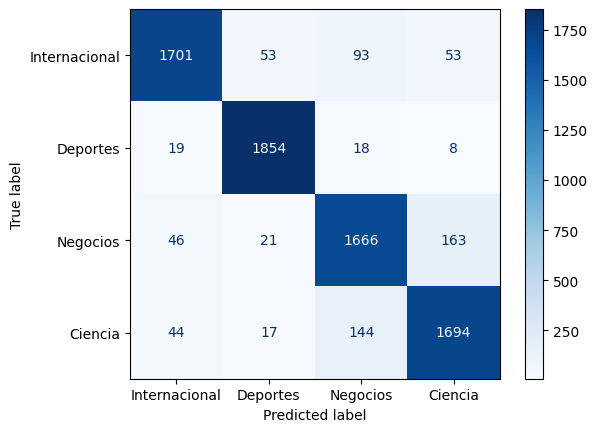

In [ ]:
classifier = estimator(model, class_names)

display = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plot.cm.Blues
)

In [ ]:
y_pred = classifier.predict(X_test)
print(classification_report(y_pred,y_test,target_names=class_names  ))

238/238 [==============================] - 1s 3ms/step
               precision    recall  f1-score   support

Internacional       0.90      0.94      0.92      1810
     Deportes       0.98      0.95      0.96      1945
     Negocios       0.88      0.87      0.87      1921
      Ciencia       0.89      0.88      0.89      1918

     accuracy                           0.91      7594
    macro avg       0.91      0.91      0.91      7594
 weighted avg       0.91      0.91      0.91      7594



## Red Neuronal con Dropout

- Se utiliza el mismo modelo que en la red neuronal sin Dropout.

### Entrenamiento

In [ ]:
modelD = Sequential([
  vectorize_layer,
  Linear(40, activation='relu'),
  layers.Dropout(0.3),
  Linear(4, activation='softmax')
])

In [ ]:
modelD.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #0.001
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
modelD.fit(
    x= X_train,
    y= y_train,
    epochs=2,
    batch_size=32,
    verbose='auto',
    validation_data=(X_val, y_val),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

Epoch 1/2
3475/3475 [==============================] - 22s 6ms/step - loss: 0.3323 - accuracy: 0.8928 - val_loss: 0.2737 - val_accuracy: 0.9068
Epoch 2/2
3475/3475 [==============================] - 25s 7ms/step - loss: 0.1869 - accuracy: 0.9358 - val_loss: 0.2896 - val_accuracy: 0.9022


In [ ]:
modelD.evaluate(
    x=X_test,
    y=y_test,
    batch_size=None,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
)

238/238 [==============================] - 1s 4ms/step - loss: 0.2734 - accuracy: 0.9168


[0.2734418511390686, 0.9167764186859131]

238/238 [==============================] - 1s 3ms/step


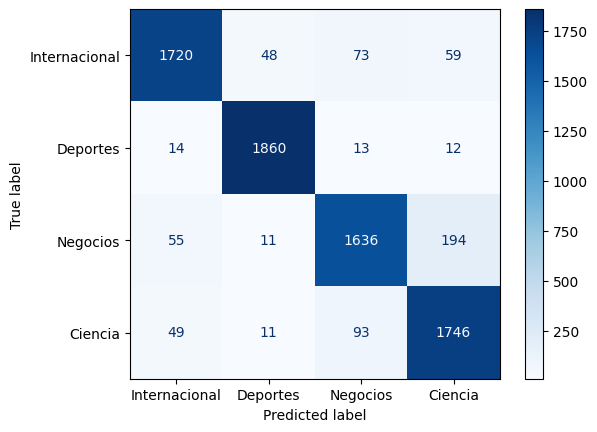

In [ ]:
classifierD = estimator(modelD, class_names)

displayD = ConfusionMatrixDisplay.from_estimator(
        classifierD,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plot.cm.Blues
)

In [ ]:
y_predD = classifierD.predict(X_test)
print(classification_report(y_predD,y_test,target_names=class_names  ))

238/238 [==============================] - 1s 5ms/step
               precision    recall  f1-score   support

Internacional       0.91      0.94      0.92      1838
     Deportes       0.98      0.96      0.97      1930
     Negocios       0.86      0.90      0.88      1815
      Ciencia       0.92      0.87      0.89      2011

     accuracy                           0.92      7594
    macro avg       0.92      0.92      0.92      7594
 weighted avg       0.92      0.92      0.92      7594



## Naive Bayes

### TF-IDF sin stop words y con lematización

- Unir datos de entrenamiento y prueba

In [ ]:
df_aux = pd.concat([train_df, test_df], axis=0)

- Lematización

In [ ]:
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def lemmatize_words(text):  #funcion obtenida con chatgpt
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    filter_words = [word for word in lemmatized_words if word not in stop_words]
    return ' '.join(filter_words)

df_aux['lem_text'] = df_aux['Text'].apply(lemmatize_words)
df_aux.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Class,Title,Description,Text,lem_text
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st bears claw back into the black reuters...,wall st bear claw back black reutersreuters sh...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace reut...,carlyle look toward commercial aerospace reute...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks outlook reutersre...,oil economy cloud stock outlook reutersreuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,iraq halt oil export main southern pipeline re...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil prices soar to alltime record posing new m...,oil price soar alltime record pose new menace ...


### Entrenamiento

- Librerias

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

- División de datos

In [ ]:
X = df_aux['lem_text'].values
y = df_aux['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 123)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
bayes_pred = MultinomialNB()

start = time.time()
bayes_pred.fit(X_train_tfidf, y_train)
print("Tiempo de entrenamiento: ",time.time()-start)

Tiempo de entrenamiento:  0.17600083351135254


In [ ]:
start = time.time()
predictions = bayes_pred.predict(X_test_tfidf)
print("Tiempo de prediccción: ",time.time()-start)

Tiempo de prediccción:  0.033562660217285156


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7448
           1       0.95      0.98      0.96      7445
           2       0.87      0.87      0.87      7457
           3       0.89      0.87      0.88      7342

    accuracy                           0.91     29692
   macro avg       0.90      0.91      0.90     29692
weighted avg       0.90      0.91      0.90     29692



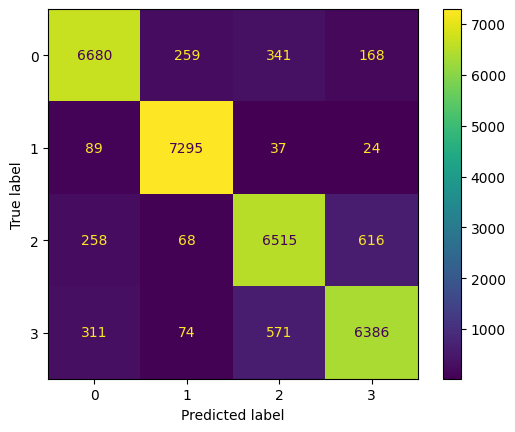

In [ ]:
cm = confusion_matrix(y_test, predictions)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
disp.plot()
plt.show()

## Árbol de Decisión

### Entrenamiento

In [ ]:
ClasificacionAD = DecisionTreeClassifier(criterion='gini',random_state=0)

start = time.time()
ClasificacionAD.fit(X_train_tfidf, y_train)
print("Tiempo de entrenamiento: ", time.time()-start)

Tiempo de entrenamiento:  87.41685009002686


In [ ]:
start = time.time()
Y_ClasificacionAD = ClasificacionAD.predict(X_test_tfidf)
print("Tiempo de predicción: ", time.time()-start)

Tiempo de predicción:  0.054976701736450195


In [ ]:
print(classification_report(y_test, Y_ClasificacionAD))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7448
           1       0.85      0.87      0.86      7445
           2       0.75      0.75      0.75      7457
           3       0.75      0.73      0.74      7342

    accuracy                           0.79     29692
   macro avg       0.79      0.79      0.79     29692
weighted avg       0.79      0.79      0.79     29692



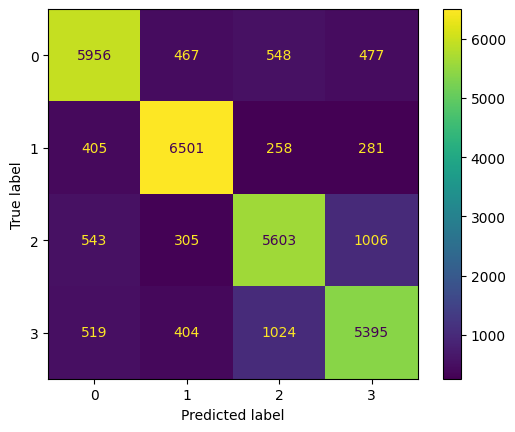

In [ ]:
cm = confusion_matrix(y_test, Y_ClasificacionAD)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(Y_ClasificacionAD))
disp.plot()
plt.show()

## Support Vector Machines

### Entrenamiento

In [ ]:
ModeloSVM_1 = SVC(kernel='linear')

start = time.time()
ModeloSVM_1.fit(X_train_tfidf, y_train)
print("Tiempo de entrenamiento: ",time.time()-start)

Tiempo de entrenamiento:  1541.8182644844055


In [ ]:
start = time.time()
Clasificaciones_1 = ModeloSVM_1.predict(X_test_tfidf)
print("Tiempo de predicción: ",time.time()-start)

Tiempo de predicción:  202.22921657562256


In [ ]:
print(classification_report(y_test, Clasificaciones_1))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      7448
           1       0.96      0.98      0.97      7445
           2       0.89      0.89      0.89      7457
           3       0.89      0.90      0.90      7342

    accuracy                           0.92     29692
   macro avg       0.92      0.92      0.92     29692
weighted avg       0.92      0.92      0.92     29692



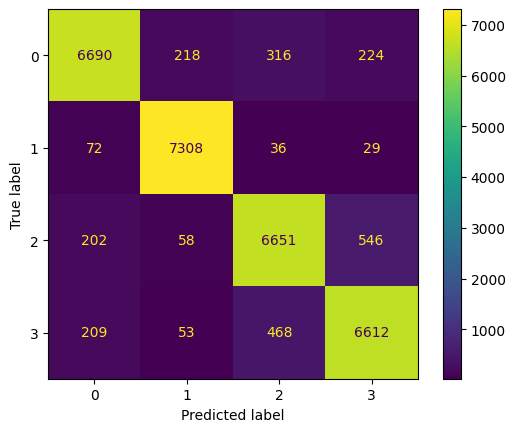

In [ ]:
cm = confusion_matrix(y_test, Clasificaciones_1)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(Clasificaciones_1))
disp.plot()
plt.show()

## K-Nearest Neighbors (KNN)

### Entrenamiento

In [ ]:
KNN_pred = KNeighborsClassifier()
start = time.time()
KNN_pred.fit(X_train_tfidf, y_train)
print("Tiempo de entrenamiento: ", time.time() - start)

Tiempo de entrenamiento:  0.016132831573486328


In [ ]:
start = time.time()
predictions = KNN_pred.predict(X_test_tfidf)
print("Tiempo de predicción: ", time.time() - start)

Tiempo de predicción:  1451.4989731311798


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7448
           1       0.94      0.97      0.95      7445
           2       0.86      0.87      0.87      7457
           3       0.89      0.85      0.87      7342

    accuracy                           0.90     29692
   macro avg       0.90      0.90      0.90     29692
weighted avg       0.90      0.90      0.90     29692



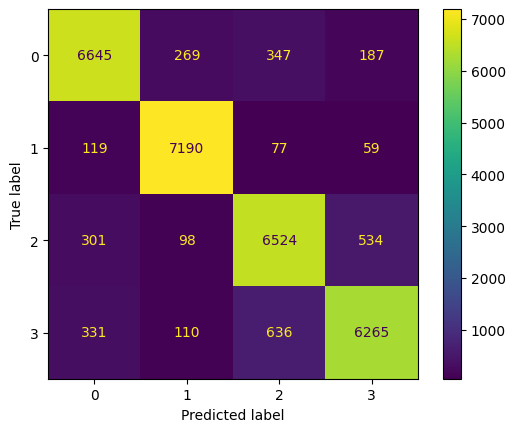

In [ ]:
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
disp.plot()
plt.show()

## Ramdom forest

### Entrenamiento

In [ ]:
ClasificacionRF = RandomForestClassifier(criterion='gini', random_state=0)

start = time.time()
ClasificacionRF.fit(X_train_tfidf, y_train)
print("Tiempo de entrenamiento: ", time.time() - start)

Tiempo de entrenamiento:  475.50550413131714


In [ ]:
start = time.time()
Y_ClasificacionRF = ClasificacionRF.predict(X_test_tfidf)
print("Tiempo de predicción: ", time.time() - start)

Tiempo de predicción:  2.5400304794311523


In [ ]:
print(classification_report(y_test, Y_ClasificacionRF))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      7448
           1       0.92      0.97      0.95      7445
           2       0.87      0.86      0.86      7457
           3       0.87      0.86      0.86      7342

    accuracy                           0.89     29692
   macro avg       0.89      0.89      0.89     29692
weighted avg       0.89      0.89      0.89     29692



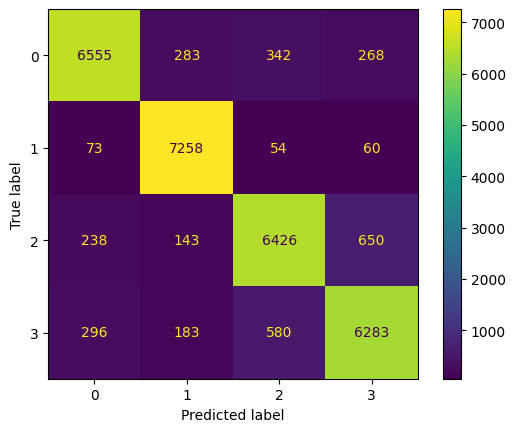

In [ ]:
cm = confusion_matrix(y_test, Y_ClasificacionRF)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(Y_ClasificacionRF))
disp.plot()
plt.show()

## BERT

In [33]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 54.4 MB/s eta 0:00:00


In [34]:
import tensorflow_hub as hub
import tensorflow_text as text

In [35]:
# Define a function to convert the label to a one-hot encoding
def convert_label_to_one_hot(text, label):
    one_hot_label = tf.one_hot(label, 4)
    return text, one_hot_label

# Apply the function to the dataset using map()
raw_train_ds = raw_train_ds.map(convert_label_to_one_hot)
raw_val_ds = raw_val_ds.map(convert_label_to_one_hot)
raw_test_ds = raw_test_ds.map(convert_label_to_one_hot)

batch_size = 16
train_ds = raw_train_ds.shuffle(40538).batch(batch_size)
val_ds = raw_val_ds.batch(batch_size)
test_ds = raw_test_ds.batch(batch_size)

In [36]:
for test_text, test_target in train_ds.take(1):
    print(test_text[0],test_text[1], test_target[0])

tf.Tensor(b'opec cartel faces dilemma as oil prices fluctuateearly last summer opec looked as though it had successfully absorbed tremendous shocks to the oil market a strike in venezuela ethnic clashes in nigeria attacks on foreign workers in saudi arabia a war in iraq', shape=(), dtype=string) tf.Tensor(b'frances makes impact on dolphinsa loss of power at dolphins headquarters on saturday wasn 39t the only impact hurricane frances has made on the franchise of the nine players who didn 39t travel to new orleans for friday 39s 2019 ', shape=(), dtype=string) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


### Modelo

In [37]:
bert_model_path = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_preprocess_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

- Capa de Preprocesamiento

In [38]:
bert_preprocess_model = hub.KerasLayer(bert_preprocess_path)

In [39]:
preprocess_output = bert_preprocess_model(test_text)
preprocess_output

{'input_word_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
 array([[  101,  6728,  8586, ...,     0,     0,     0],
        [  101, 10360,  3084, ...,     0,     0,     0],
        [  101, 13138,  2575, ...,     0,     0,     0],
        ...,
        [  101,  8412,  3709, ...,     0,     0,     0],
        [  101,  2013, 10900, ...,     0,     0,     0],
        [  101,  2634, 10299, ...,     0,     0,     0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0

- BERT

In [40]:
bert_model = hub.KerasLayer(bert_model_path, trainable=False)
bert_model(preprocess_output)['pooled_output']

<tf.Tensor: shape=(16, 512), dtype=float32, numpy=
array([[ 0.8253783 ,  0.8600333 ,  0.04252807, ...,  0.10810506,
        -0.45921278, -0.9786928 ],
       [ 0.58530957,  0.9428049 ,  0.03660142, ..., -0.1322897 ,
        -0.590157  , -0.64323044],
       [ 0.76352286,  0.6258958 , -0.02937633, ..., -0.03738722,
        -0.32453293,  0.18395445],
       ...,
       [ 0.74222803, -0.91792065,  0.23999548, ...,  0.1996756 ,
        -0.40172106, -0.4905487 ],
       [ 0.73088616, -0.11930569, -0.10878266, ..., -0.28955758,
        -0.47674036, -0.9542968 ],
       [-0.17888607,  0.98126304, -0.04751549, ...,  0.02809603,
        -0.63525265, -0.9495635 ]], dtype=float32)>

- Modelo

In [41]:
def get_model(bert_model_path, bert_preprocess_model, trainable):
    preprocess_model = hub.KerasLayer(bert_preprocess_model)
    bert_model = hub.KerasLayer(bert_model_path, trainable=trainable)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocess_text = bert_preprocess_model(text_input)
    bert_output = bert_model(preprocess_text)['pooled_output']
    x = tf.keras.layers.Dense(128, activation='relu')(bert_output)
    output = tf.keras.layers.Dense(4)(x)
    small_bert = tf.keras.Model(text_input, output)
    return small_bert

freeze_bert = get_model(bert_model_path, bert_preprocess_model, trainable=False)

In [42]:
freeze_bert(test_text)

<tf.Tensor: shape=(16, 4), dtype=float32, numpy=
array([[-0.28787258,  0.51090044,  1.0862664 ,  1.1247712 ],
       [-0.15085292,  0.8753804 ,  0.51899004,  0.24328277],
       [-0.09370159,  0.40169945,  0.9805064 ,  0.75862557],
       [-0.66560936,  0.9293699 ,  0.5402104 ,  0.29870307],
       [ 0.06270113,  0.361592  ,  1.027256  ,  0.32091984],
       [-0.24077979,  0.81324065,  0.69586384,  0.76294214],
       [-0.41495585,  0.5011185 ,  0.6728263 ,  0.31569678],
       [ 0.04096322,  0.4677511 ,  0.69384027,  0.3682333 ],
       [-0.1180884 ,  0.549535  ,  0.46422517,  0.2991556 ],
       [ 0.23329572,  0.4599059 ,  0.79179716,  0.62501657],
       [-0.4664019 ,  0.64348024,  1.0128192 ,  0.276591  ],
       [ 0.04034133,  0.75057036,  0.5062194 ,  0.84290785],
       [ 0.08230428,  0.34544528,  2.2770355 ,  1.2199572 ],
       [-0.27084616,  0.6750698 ,  0.8714748 ,  0.36423117],
       [-0.61832845,  0.85920286,  1.3923521 ,  0.54908687],
       [-0.70260483,  0.37699145,  0

In [43]:
freeze_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

### Entrenamiento

- Entrenamiento de la primera capa

In [44]:
lr = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

freeze_bert.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    optimizer=opt,
                    metrics=['accuracy'])

In [45]:
epochs = 3
history = freeze_bert.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/3
6949/6949 [==============================] - 398s 56ms/step - loss: 0.4265 - accuracy: 0.8500 - val_loss: 0.3527 - val_accuracy: 0.8745
Epoch 2/3
6949/6949 [==============================] - 403s 58ms/step - loss: 0.3648 - accuracy: 0.8713 - val_loss: 0.3330 - val_accuracy: 0.8809
Epoch 3/3
6949/6949 [==============================] - 391s 56ms/step - loss: 0.3499 - accuracy: 0.8761 - val_loss: 0.3387 - val_accuracy: 0.8789


- Evaluación primera capa

In [46]:
freeze_bert.evaluate(test_ds)

475/475 [==============================] - 25s 53ms/step - loss: 0.3605 - accuracy: 0.8744


[0.360536128282547, 0.874374508857727]

- Entrenamiento de todas las capas

In [47]:
full_bert = get_model(bert_model_path, bert_preprocess_model, trainable=True)

In [48]:
full_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [49]:
lr = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

full_bert.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    optimizer=opt,
                    metrics=['accuracy'])

In [51]:
epochs = 1
history = full_bert.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

6949/6949 [==============================] - 816s 117ms/step - loss: 0.2779 - accuracy: 0.9067 - val_loss: 0.2382 - val_accuracy: 0.9171


- Evaluación de todas las capas

In [52]:
full_bert.evaluate(test_ds)

475/475 [==============================] - 25s 52ms/step - loss: 0.2394 - accuracy: 0.9223


[0.2394104152917862, 0.9223070740699768]

238/238 [==============================] - 26s 107ms/step


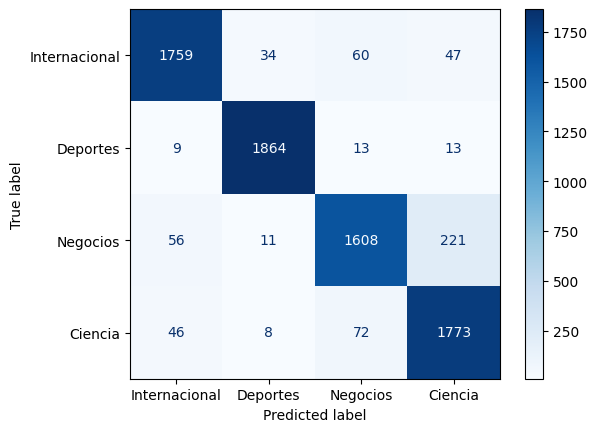

In [55]:
classifierB = estimator(full_bert, class_names)

displayB = ConfusionMatrixDisplay.from_estimator(
        classifierB,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plot.cm.Blues
)

In [56]:
y_predB = classifierB.predict(X_test)
print(classification_report(y_predB,y_test,target_names=class_names  ))

238/238 [==============================] - 25s 107ms/step
               precision    recall  f1-score   support

Internacional       0.93      0.94      0.93      1870
     Deportes       0.98      0.97      0.98      1917
     Negocios       0.85      0.92      0.88      1753
      Ciencia       0.93      0.86      0.90      2054

     accuracy                           0.92      7594
    macro avg       0.92      0.92      0.92      7594
 weighted avg       0.92      0.92      0.92      7594



## Gráficas de Tiempos de entrenamiento y predicción

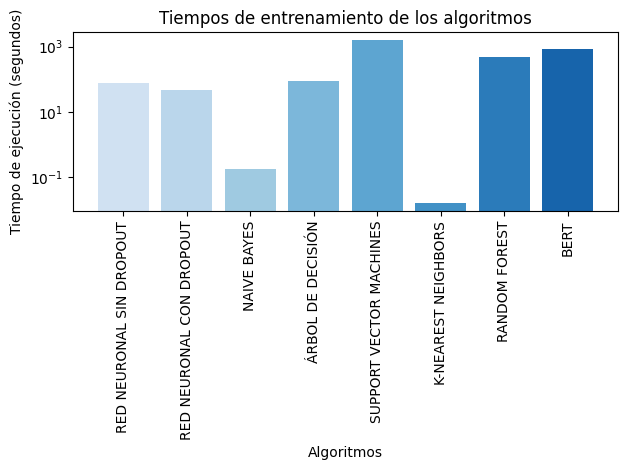

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo de los tiempos de ejecución de los algoritmos (en segundos)
tiempos_ejecucion = [76, 47, 0.176, 87.416, 1541.818, 0.016, 475.505, 816]

# Nombres de los algoritmos
nombres_algoritmos = ['RED NEURONAL SIN DROPOUT', 'RED NEURONAL CON DROPOUT',
                      'NAIVE BAYES', 'ÁRBOL DE DECISIÓN', 'SUPPORT VECTOR MACHINES',
                      'K-NEAREST NEIGHBORS', 'RANDOM FOREST', 'BERT']

# Generar la paleta de colores azules
colores = plt.cm.Blues(np.linspace(0.2, 0.8, len(tiempos_ejecucion)))

# Crear la gráfica de barras
plt.bar(nombres_algoritmos, tiempos_ejecucion, color=colores)

# Agregar etiquetas y título
plt.xlabel('Algoritmos')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Tiempos de entrenamiento de los algoritmos')

# Rotar los nombres de los algoritmos en el eje x
plt.xticks(rotation=90)

# Ajustar el espaciado para evitar la superposición de los nombres
plt.tight_layout()

# Configurar la escala logarítmica en el eje y
plt.yscale('log')

# Mostrar la gráfica
plt.show()

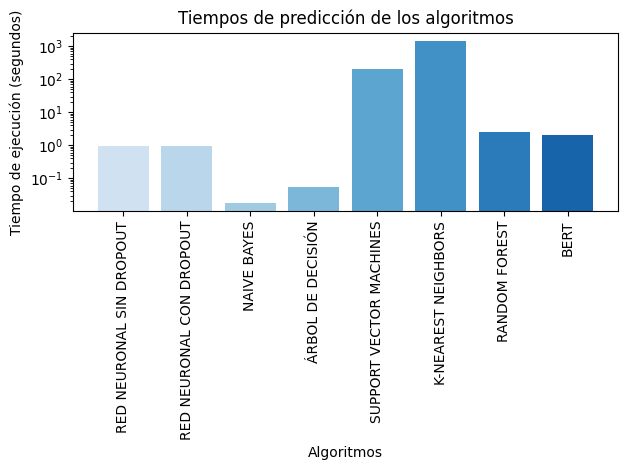

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo de los tiempos de ejecución de los algoritmos (en segundos)
tiempos_ejecucion = [0.952, 0.952, 0.018, 0.054, 202.229, 1451.498, 2.540, 2]

# Nombres de los algoritmos
nombres_algoritmos = ['RED NEURONAL SIN DROPOUT', 'RED NEURONAL CON DROPOUT',
                      'NAIVE BAYES', 'ÁRBOL DE DECISIÓN', 'SUPPORT VECTOR MACHINES',
                      'K-NEAREST NEIGHBORS', 'RANDOM FOREST', 'BERT']

# Generar la paleta de colores azules
colores = plt.cm.Blues(np.linspace(0.2, 0.8, len(tiempos_ejecucion)))

# Crear la gráfica de barras
plt.bar(nombres_algoritmos, tiempos_ejecucion, color=colores)

# Agregar etiquetas y título
plt.xlabel('Algoritmos')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Tiempos de predicción de los algoritmos')

# Rotar los nombres de los algoritmos en el eje x
plt.xticks(rotation=90)

# Ajustar el espaciado para evitar la superposición de los nombres
plt.tight_layout()

# Configurar la escala logarítmica en el eje y
plt.yscale('log')

# Mostrar la gráfica
plt.show()


## Referencias

- https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?select=train.csv

- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

- https://www.tensorflow.org/api_docs/python/tf/keras/Model

- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

- https://www.tensorflow.org/guide/keras/train_and_evaluate